# Figure 1 - Basic Comparison of Algorithms

April 3, 2022

The following plots outline the basic

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [92]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle

### Train RNN on four targets

In [6]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### BPTT, RFLO and REINFORCE with the same parameters

20it [00:00, 198.28it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb5e6166120>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


5000it [00:10, 455.53it/s]


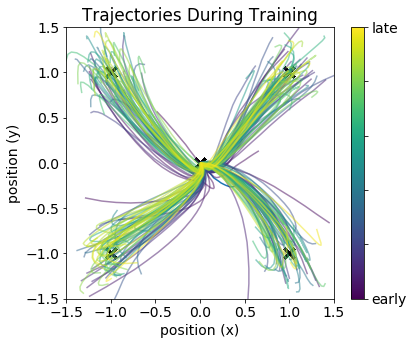

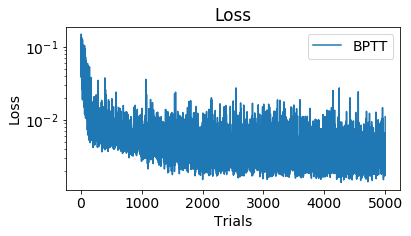

In [86]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
bptt = BPTT(net0,apply_to=['w_rec'],online=False) # something strange happening here
sim0.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['loss'], plot=True, plot_freq=20)




5000it [00:11, 422.88it/s]


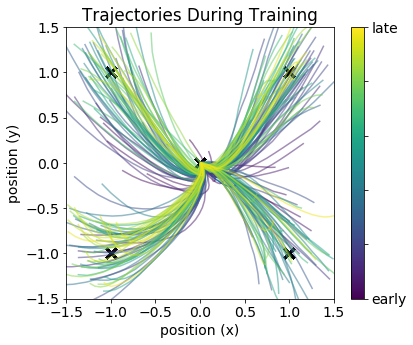

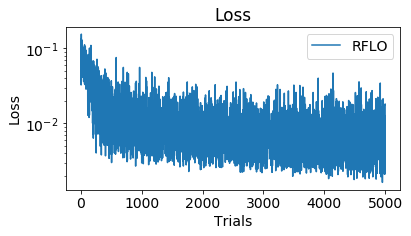

In [83]:
net1 = RNN(params)
sim1 = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)


50000it [01:34, 528.18it/s]


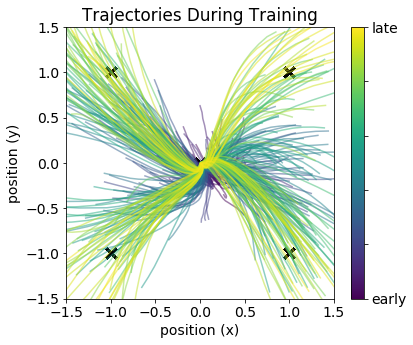

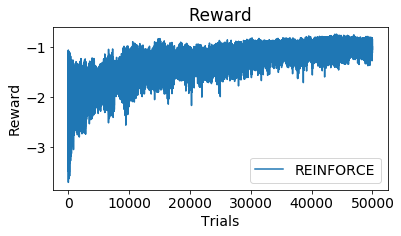

In [80]:
net2 = RNN(params)
sim2 = Simulation(net2)
reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False, tau_reward=5)
sim2.run_session(n_trials=50000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)


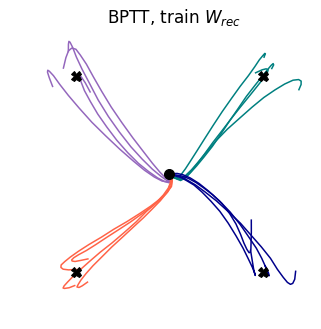

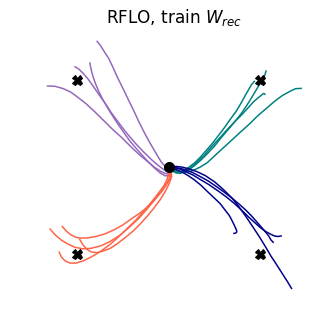

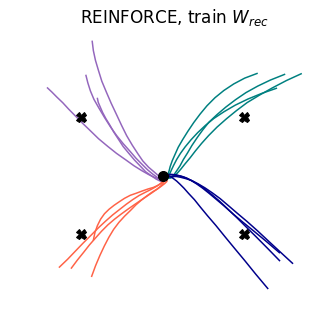

In [87]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='BPTT, train '+r'$W_{rec}$')
fig1 = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='RFLO, train '+r'$W_{rec}$')
fig2 = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='REINFORCE, train '+r'$W_{rec}$')


save = True
if save:
    fig0.savefig('fig1-BPTT')
    fig1.savefig('fig1-RFLO')
    fig2.savefig('fig1-REINFORCE')

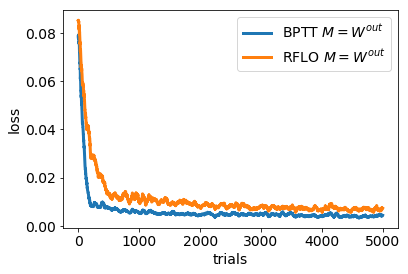

In [88]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),50)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),50)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('loss')
plt.show()

#ax.fill_between(np.arange(len(av1)),av1-std1,av1+std1,alpha=0.5)
#std1 = uniform_filter1d(np.std(sim1.session_probes['loss'],axis=1),50)


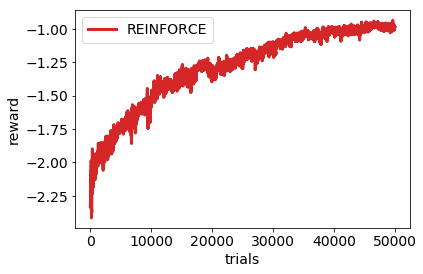

In [90]:
fig,ax = plt.subplots(1,1)
av2 = uniform_filter1d(np.mean(sim2.session_probes['reward'],axis=1),50)
ax.plot(av2,linewidth=lw,label='REINFORCE',color='C3')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('reward')
plt.show()


### Compare alignment of M for RFLO

In [178]:
def realign_matrix(W,n_change,rng=np.random.RandomState(1964),zero=True,scale=1):
    
    """ remove certain rows from matrix 
    
    method 1:
        assign random elements of matrix to 0
    method 2: 
        assign random elements to new set of uniform random values, scaled by 'scale'
    

    """
    dim = W.shape[1]
    
    if zero:
        ident = np.identity(dim)
        # remove rows
        idx = rng.choice(np.arange(0,dim),size=n_change,replace=False)
        ident[idx,:] = 0
        W_realigned = W @ ident
        
    else:
        W_realigned = W.copy()
        idx = rng.choice(np.arange(0,len(W.ravel())),size=n_change,replace=False)
        W_realigned.ravel()[idx] = scale*(2*rng.rand(len(idx)) - 1)/dim**0.5 
        W_realigned=W_realigned.reshape(-1,dim)
        
#     else:
#         W_realigned = W + scale*rng.randn(W.shape[0],W.shape[1])
#         W_realigned /= np.linalg.norm(W_realigned)
    
    
    return W_realigned

In [183]:
""" SELECT B """
    
def choose_aligned(W,overlap=0.75,n_change=30,tolerance=0.05,loop=1000,rng=np.random.RandomState(1964),zero=False,verbose=True):

    if overlap == 1:
        n_change = 0
    
    for i in range(loop):

        M = realign_matrix(W,n_change=n_change,rng=rng,zero=zero)
        norm,angle = return_norm_and_angle(W,M)

        if angle < overlap + tolerance and angle > overlap - tolerance:
            if verbose: print('\rM norm: {:.2f}'.format(norm) + '\t M angle: {:.2f}, {} iterations'.format(angle,i),end='')
            return M
            
        else:
            if verbose: print('\rNO OVERLAP M angle: {:.2f}, {} iterations'.format(angle,i),end='')
                
    return None # if no successful matrix

    


In [149]:
len(net0.w_out.copy().T)

50

In [194]:
M = choose_aligned(net0.w_out.copy(),n_change=100,overlap=0.,zero=False,tolerance=0.01,loop=1000)

M norm: 1.85	 M angle: 0.00, 10 iterations

In [197]:
M.shape

(2, 50)

In [198]:
net0.w_out.shape

(2, 50)


0it [00:00, ?it/s]
26it [00:00, 256.48it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations


67it [00:00, 288.52it/s]
107it [00:00, 313.78it/s]
152it [00:00, 344.22it/s]
196it [00:00, 366.81it/s]
239it [00:00, 381.91it/s]
281it [00:00, 391.37it/s]
322it [00:00, 396.32it/s]
363it [00:00, 399.92it/s]
407it [00:01, 409.05it/s]
449it [00:01, 411.02it/s]
490it [00:01, 404.82it/s]
531it [00:01, 402.76it/s]
577it [00:01, 417.16it/s]
621it [00:01, 415.93it/s]
665it [00:01, 421.02it/s]
709it [00:01, 424.77it/s]
752it [00:01, 424.92it/s]
796it [00:01, 427.52it/s]
839it [00:02, 427.51it/s]
882it [00:02, 423.47it/s]
925it [00:02, 420.84it/s]
968it [00:02, 410.99it/s]
1010it [00:02, 362.50it/s]
1055it [00:02, 383.72it/s]
1098it [00:02, 395.05it/s]
1141it [00:02, 398.22it/s]
1185it [00:02, 408.62it/s]
1228it [00:03, 413.45it/s]
1271it [00:03, 418.18it/s]
1314it [00:03, 414.60it/s]
1356it [00:03, 415.34it/s]
1399it [00:03, 417.25it/s]
1441it [00:03, 401.63it/s]
1484it [00:03, 407.89it/s]
1527it [00:03, 413.19it/s]
1569it [00:03, 412.71it/s]
1611it [00:03, 411.75it/s]
1655it [00:04, 418.70it

M norm: 1.02	 M angle: 0.80, 6 iterations


81it [00:00, 385.20it/s]
125it [00:00, 399.85it/s]
172it [00:00, 418.15it/s]
218it [00:00, 428.17it/s]
261it [00:00, 423.24it/s]
307it [00:00, 433.13it/s]
353it [00:00, 440.71it/s]
400it [00:00, 448.88it/s]
444it [00:01, 437.48it/s]
491it [00:01, 445.22it/s]
535it [00:01, 438.64it/s]
579it [00:01, 435.31it/s]
623it [00:01, 436.22it/s]
671it [00:01, 446.56it/s]
717it [00:01, 449.28it/s]
762it [00:01, 447.55it/s]
810it [00:01, 455.28it/s]
858it [00:01, 460.43it/s]
905it [00:02, 455.00it/s]
953it [00:02, 460.31it/s]
1000it [00:02, 455.55it/s]
1046it [00:02, 446.59it/s]
1091it [00:02, 445.41it/s]
1137it [00:02, 448.90it/s]
1182it [00:02, 443.67it/s]
1228it [00:02, 446.85it/s]
1274it [00:02, 449.72it/s]
1320it [00:02, 452.40it/s]
1366it [00:03, 449.18it/s]
1413it [00:03, 454.01it/s]
1459it [00:03, 452.63it/s]
1505it [00:03, 440.02it/s]
1550it [00:03, 433.86it/s]
1596it [00:03, 440.37it/s]
1641it [00:03, 439.68it/s]
1686it [00:03, 432.84it/s]
1733it [00:03, 442.67it/s]
1780it [00:04, 449.51

M norm: 1.35	 M angle: 0.60, 3 iterations


83it [00:00, 397.32it/s]
130it [00:00, 414.87it/s]
176it [00:00, 425.90it/s]
223it [00:00, 436.39it/s]
271it [00:00, 448.45it/s]
320it [00:00, 457.01it/s]
365it [00:00, 453.41it/s]
413it [00:00, 459.14it/s]
459it [00:01, 457.00it/s]
504it [00:01, 449.83it/s]
549it [00:01, 447.09it/s]
594it [00:01, 445.15it/s]
641it [00:01, 446.42it/s]
687it [00:01, 450.07it/s]
735it [00:01, 458.49it/s]
781it [00:01, 452.47it/s]
827it [00:01, 453.77it/s]
874it [00:01, 457.17it/s]
920it [00:02, 455.63it/s]
966it [00:02, 443.39it/s]
1012it [00:02, 446.83it/s]
1057it [00:02, 429.42it/s]
1101it [00:02, 422.01it/s]
1147it [00:02, 431.15it/s]
1194it [00:02, 440.23it/s]
1241it [00:02, 442.16it/s]
1289it [00:02, 450.50it/s]
1336it [00:02, 455.42it/s]
1382it [00:03, 444.01it/s]
1428it [00:03, 446.51it/s]
1473it [00:03, 446.47it/s]
1518it [00:03, 445.51it/s]
1563it [00:03, 427.21it/s]
1606it [00:03, 426.92it/s]
1653it [00:03, 438.45it/s]
1698it [00:03, 435.15it/s]
1742it [00:03, 428.17it/s]
1787it [00:04, 433.82

M norm: 1.59	 M angle: 0.40, 9 iterations


75it [00:00, 337.67it/s]
121it [00:00, 362.51it/s]
166it [00:00, 384.15it/s]
215it [00:00, 408.85it/s]
261it [00:00, 421.75it/s]
306it [00:00, 429.41it/s]
353it [00:00, 440.83it/s]
399it [00:00, 446.10it/s]
443it [00:01, 437.87it/s]
488it [00:01, 439.52it/s]
535it [00:01, 446.45it/s]
581it [00:01, 441.81it/s]
626it [00:01, 438.84it/s]
670it [00:01, 436.15it/s]
715it [00:01, 439.37it/s]
759it [00:01, 435.85it/s]
803it [00:01, 434.80it/s]
850it [00:01, 443.70it/s]
897it [00:02, 450.32it/s]
943it [00:02, 447.18it/s]
989it [00:02, 449.29it/s]
1036it [00:02, 453.89it/s]
1082it [00:02, 452.15it/s]
1128it [00:02, 449.50it/s]
1173it [00:02, 448.37it/s]
1218it [00:02, 444.23it/s]
1263it [00:02, 438.96it/s]
1307it [00:02, 402.63it/s]
1348it [00:03, 398.05it/s]
1394it [00:03, 413.09it/s]
1438it [00:03, 418.75it/s]
1481it [00:03, 421.89it/s]
1526it [00:03, 429.50it/s]
1572it [00:03, 434.82it/s]
1616it [00:03, 365.03it/s]
1661it [00:03, 384.39it/s]
1708it [00:03, 405.52it/s]
1754it [00:04, 418.35i

M norm: 1.88	 M angle: 0.00, 1 iterations


86it [00:00, 410.56it/s]
131it [00:00, 419.72it/s]
177it [00:00, 429.12it/s]
221it [00:00, 425.26it/s]
264it [00:00, 425.22it/s]
312it [00:00, 437.42it/s]
359it [00:00, 445.84it/s]
402it [00:00, 411.05it/s]
443it [00:01, 401.02it/s]
487it [00:01, 410.51it/s]
528it [00:01, 395.98it/s]
569it [00:01, 399.40it/s]
609it [00:01, 381.77it/s]
648it [00:01, 363.43it/s]
685it [00:01, 364.17it/s]
722it [00:01, 352.11it/s]
759it [00:01, 356.06it/s]
795it [00:02, 352.88it/s]
831it [00:02, 347.57it/s]
866it [00:02, 343.09it/s]
901it [00:02, 328.63it/s]
935it [00:02, 320.20it/s]
968it [00:02, 314.41it/s]
1001it [00:02, 318.53it/s]
1037it [00:02, 327.95it/s]
1070it [00:02, 317.84it/s]
1107it [00:02, 330.74it/s]
1143it [00:03, 338.90it/s]
1179it [00:03, 343.18it/s]
1214it [00:03, 338.11it/s]
1248it [00:03, 274.18it/s]
1278it [00:03, 212.74it/s]
1307it [00:03, 230.03it/s]
1334it [00:03, 240.10it/s]
1361it [00:04, 223.12it/s]
1386it [00:04, 212.34it/s]
1410it [00:04, 219.73it/s]
1433it [00:04, 220.44it/

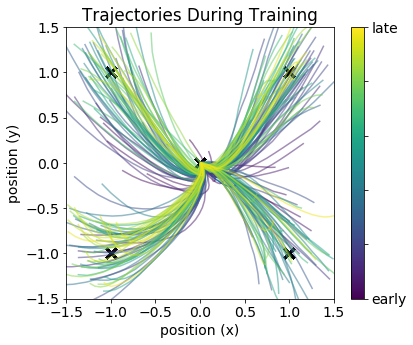

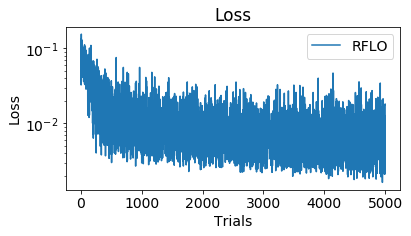

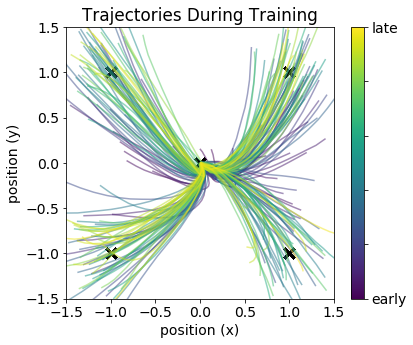

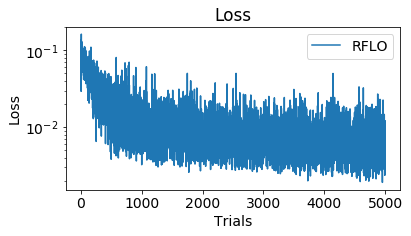

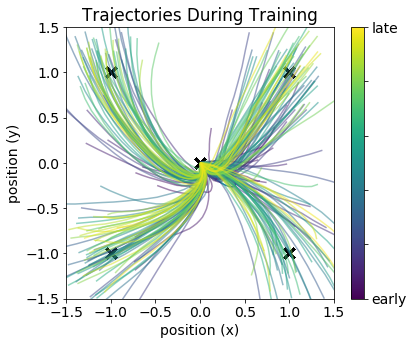

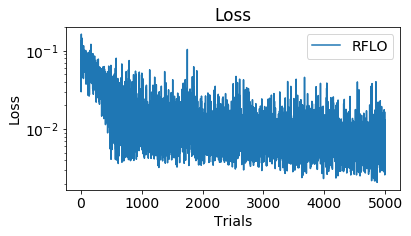

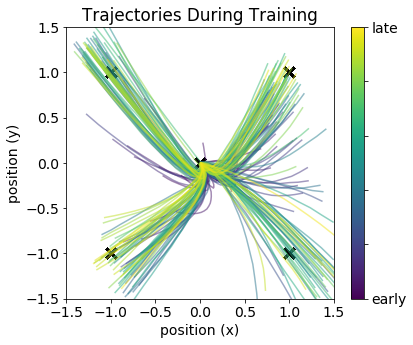

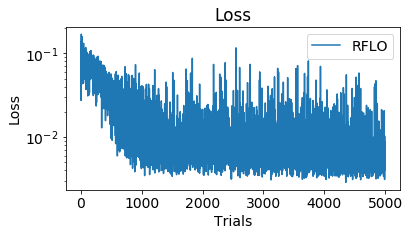

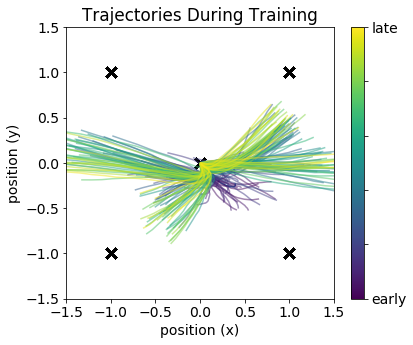

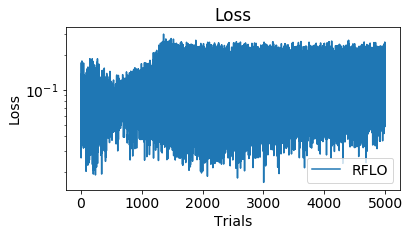

In [223]:

loss_dict = {}

overlaps = [1,0.8,0.6,0.4,0]
n_changes = [0,30,50,75,100]
for overlap, n_change in zip(overlaps,n_changes):
    
    net1a = RNN(params)
    
    M = choose_aligned(net1a.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
    net1a.set_weights(w_m = M.T)
    
    sim1a = Simulation(net1a)
    rfloa = RFLO(net1a,apply_to=['w_rec'],online=False)
    sim1a.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rfloa], probe_types=['loss'], plot=True, plot_freq=20)

    av1a = uniform_filter1d(np.mean(sim1a.session_probes['loss'],axis=1),50)
    
    loss_dict[str(overlap)] = av1a


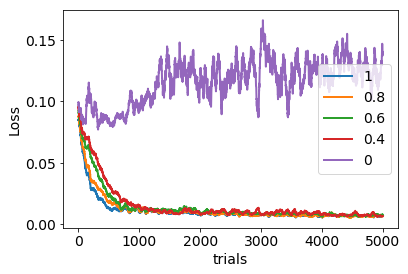

In [224]:
fig,ax = plt.subplots(1,1)
for overlap,loss in loss_dict.items():
    ax.plot(loss,label=overlap,linewidth=lw)

ax.set_ylabel('Loss')
ax.set_xlabel('trials')
ax.legend()
plt.show()

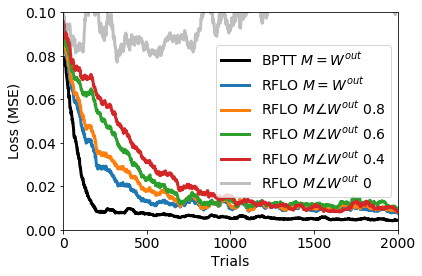

In [250]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),50)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$',color='k')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),50)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')



for overlap,loss in loss_dict.items():
    
    if overlap != '0' and overlap != '1':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{out}$ '+overlap)
        
    if overlap == '0':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{out}$ '+overlap,alpha=0.5,color='grey')

#ax.legend(bbox_to_anchor=(0.7,1))
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Loss (MSE)')
ax.set_ylim([0,0.1])
ax.set_xlim([0,2000])
plt.show()